## Content

1. [User IBM cloud API](#User-IBM-cloud-API)
2. [Initiate session](#Initiate-session)
3. [Methods](#Methods)
4. [QUBO coefficients](#QUBO-coefficients)
5. [QUBO Hamiltonian](#QUBO-Hamiltonian)
6. [VQE ansatz](#VQE-ansatz)
7. [Parameterized Quantum Circuit](#Parameterized-Quantum-Circuit)
8. [Cost function](#Cost-function)
9. [Optimization](#Optimization)
10. [Results 3 qubits](#Results-3-qubits)
11. [Results 6 qubits](#Results-6-qubits)    
12. [Results 13 qubits](#Results-13-qubits)

### User IBM cloud API

In [31]:
token_api = ''

### Initiate session

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(channel="ibm_quantum", token=token_api)

### Methods

In [33]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import Estimator, Sampler, Session
from scipy.optimize import minimize
from qiskit import transpile, execute
from qiskit.visualization import plot_circuit_layout
from qiskit.visualization import plot_error_map

###  QUBO coefficients

In [34]:
qubits = [sp.Symbol("q1"), sp.Symbol("q2"), sp.Symbol("q3")]

p1, p2, p3 = 39.5, 3.6, 87.8
N = 100
asset_3_prices = [p1, p2, p3]
function = -N + p1 * qubits[0] + p2 * qubits[1] +  p3 * qubits[2]
    
square_function = function**2

In [35]:
qubo_3_qb = square_function.expand()
qubo_3_qb

1560.25*q1**2 + 284.4*q1*q2 + 6936.2*q1*q3 - 7900.0*q1 + 12.96*q2**2 + 632.16*q2*q3 - 720.0*q2 + 7708.84*q3**2 - 17560.0*q3 + 10000

In [36]:
def qubo_matrix(init_coeffs, cost_fun):
    
    nb_qb = len(init_coeffs)
    matrix = np.zeros((nb_qb, nb_qb))
    
    for i in range(nb_qb):
        
        matrix[i,i] = cost_fun.coeff(f"q{i + 1}**2") + cost_fun.coeff(f"q{i + 1}").args[0]
        
        for j in range(i + 1, nb_qb):
            
            matrix[i,j] = cost_fun.coeff(f"q{i + 1}*q{j + 1}")
            matrix[j,i] = cost_fun.coeff(f"q{i + 1}*q{j + 1}")
            
    return matrix

In [37]:
coeffs_3_qb = qubo_matrix(asset_3_prices, qubo_3_qb)
sp.Matrix(np.triu(coeffs_3_qb))

Matrix([
[-6339.75,   284.4,   6936.2],
[       0, -707.04,   632.16],
[       0,       0, -9851.16]])

In [38]:
def gate_qubo_matrix(qubo_coeffs, qubo):
    
    nb_qb = len(qubo_coeffs)
    gate_coeffs = np.zeros((nb_qb, nb_qb))
    
    constant =  qubo.args[0]
    for i in range(nb_qb):
        
        constant += 0.5 * qubo_coeffs[i,i]
        
        gate_coeffs[i,i] = -0.5 * sum(qubo_coeffs[i])
        
        for j in range(i + 1, nb_qb):
            constant += 0.25 * qubo_coeffs[i,j]
            gate_coeffs[i,j] = qubo_coeffs[i,j] / 4
    
    return [gate_coeffs, constant]

In [39]:
gate_qubo_3_qb = gate_qubo_matrix(coeffs_3_qb, qubo_3_qb)
sp.Matrix(gate_qubo_3_qb[0])

Matrix([
[-440.425,    71.1, 1734.05],
[       0, -104.76,  158.04],
[       0,       0,  1141.4]])

###  QUBO Hamiltonian

In [40]:
def pauli_z_hamiltonian(coefficients):
    
    h = []
    nb_qubits = len(coefficients)
    
    for i in range(nb_qubits):
        h.append(('Z', [i], coefficients[i, i]))
        
    for i in range(nb_qubits):
        for j in range(i + 1, nb_qubits):
            h.append(("ZZ", [i,j], coefficients[i, j]))
    
    hamiltonian = SparsePauliOp.from_sparse_list(h, num_qubits = nb_qubits)
    
    return hamiltonian

In [41]:
hamiltonian_3_qb = pauli_z_hamiltonian(gate_qubo_3_qb[0])
hamiltonian_3_qb

SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[-440.425+0.j, -104.76 +0.j, 1141.4  +0.j,   71.1  +0.j, 1734.05 +0.j,
  158.04 +0.j])

### VQE ansatz

In [42]:
ansatz_3_qb = EfficientSU2(hamiltonian_3_qb.num_qubits, reps=1)

### Parameterized Quantum Circuit

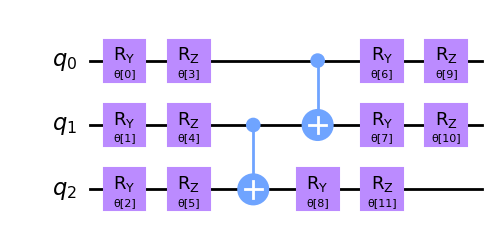

In [43]:
ansatz_3_qb.decompose().draw('mpl')

### Cost function

In [44]:
def cost_func(params, ansatz, hamiltonian, estimator):

    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    
    return energy

### Optimization

Quantum simulator

In [45]:
backend = service.backend("ibmq_qasm_simulator")
session = Session(backend=backend)
estimator = Estimator(session=session, options={"shots": 1000})

Initial guess

In [46]:
x0 = 2 * np.pi * np.random.random(len(ansatz_3_qb.parameters))

Minimize cost function using Finite Differences method (gradient approximation)

In [47]:
# res_3_fd = minimize(cost_func, x0, args=(ansatz_3_qb, hamiltonian_3_qb, estimator), method="trust-constr")

In [48]:
res_3_fd_x = [2.907e+00, 3.897e+00, 3.470e+00, 5.240e+00, 6.135e+00,
              1.466e+00,4.642e+00, 2.641e+00, 3.166e+00,3.544e+00,
              4.398e+00, 4.638e+00]

Minimize cost function using COBYLA method (gradient free)

In [49]:
#res_3_ng = minimize(cost_func, x0, args=(ansatz_3_qb, hamiltonian_3_qb, estimator), method="cobyla")

In [50]:
res_3_ng_x = [3.163e+00,  6.421e+00,  3.146e+00, 2.712e+00, 3.025e+00, 
              5.051e+00,  3.372e+00,  6.006e+00, 6.377e+00, 3.241e+00, 
              4.666e+00,  3.472e+00]

### Results 3 qubits 

#### Quantum Simulator (QS)

In [51]:
for s in service.backends():
    if 'simulator' in s.name:
        print(s.name)

simulator_stabilizer
ibmq_qasm_simulator
simulator_extended_stabilizer
simulator_mps
simulator_statevector


In [52]:
sampler = Sampler(session='ibmq_qasm_simulator', options={"shots": 1000})

In [53]:
vqe_3_fd = ansatz_3_qb.assign_parameters(res_3_fd_x)
vqe_3_fd.measure_all()
transpiled_vqe_3_fd = transpile(vqe_3_fd, backend)
vqe_3_fd_qs = sampler.run(transpiled_vqe_3_fd)

In [54]:
res_vqe_3_fd_qs = vqe_3_fd_qs.result().quasi_dists[0]

{'001': 0.038, '100': 0.01, '110': 0.445, '010': 0.016, '000': 0.081, '111': 0.344, '011': 0.017, '101': 0.049}


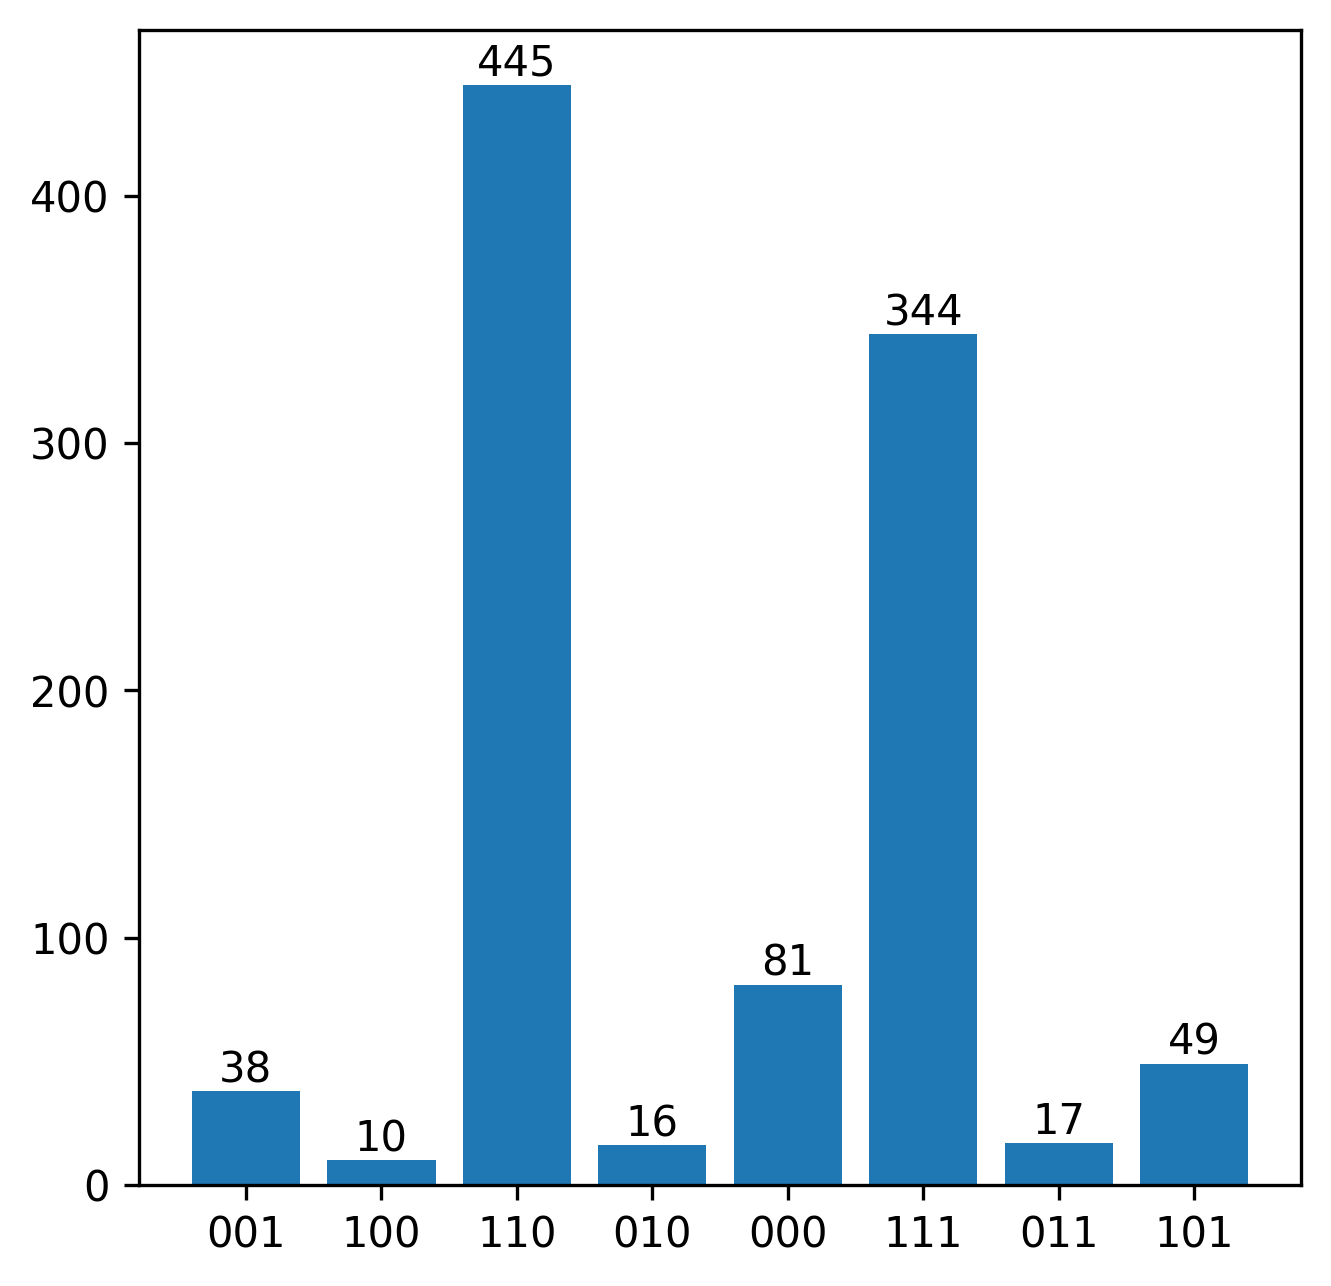

In [55]:
res_dict_3_fd = res_vqe_3_fd_qs.binary_probabilities()
print(res_dict_3_fd)
plt.figure(figsize=(5,5), dpi=300)
round_values = [round(1000 * i) for i in res_dict_3_fd.values()]
counts = plt.bar(range(len(res_dict_3_fd)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_3_fd)), list(res_dict_3_fd.keys()))
plt.show()

In [56]:
vqe_3_ng = ansatz_3_qb.assign_parameters(res_3_ng_x)
vqe_3_ng.measure_all()
transpiled_vqe_3_ng = transpile(vqe_3_ng, backend)
vqe_3_ng_qs = sampler.run(transpiled_vqe_3_ng)

In [57]:
res_vqe_3_ng_qs = vqe_3_ng_qs.result().quasi_dists[0]

{'111': 0.011, '000': 0.006, '010': 0.001, '110': 0.96, '100': 0.022}


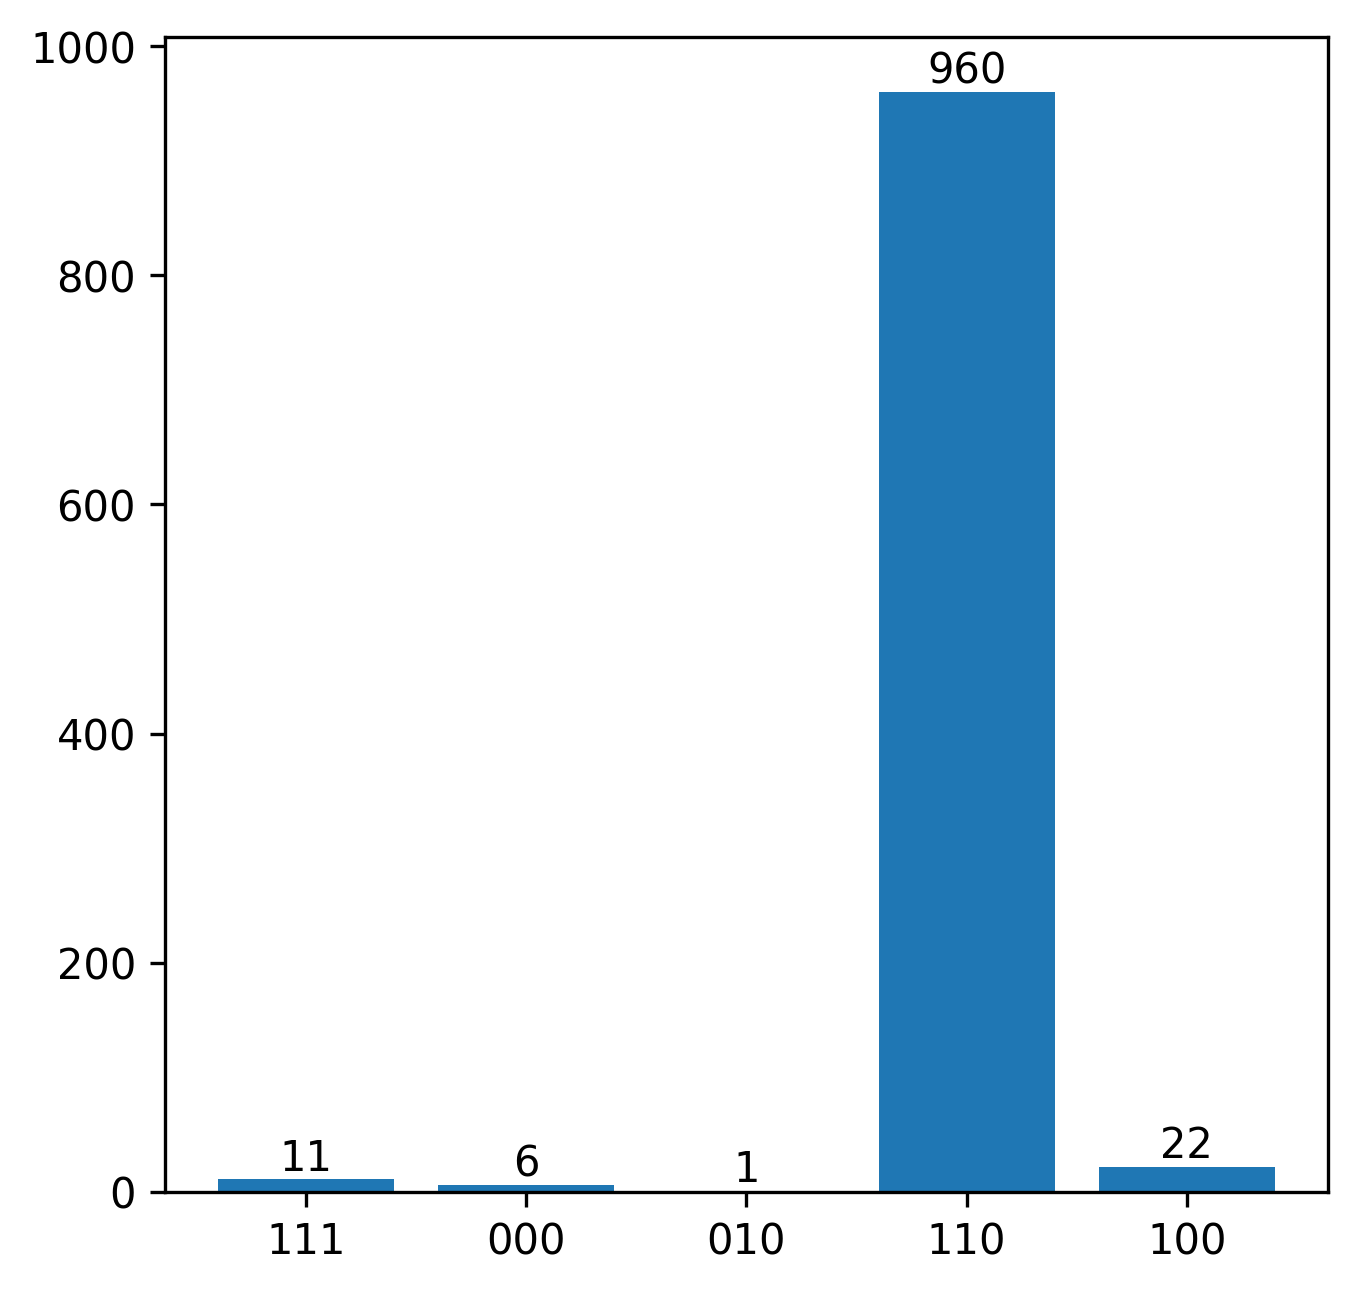

In [58]:
res_dict_3_ng = res_vqe_3_ng_qs.binary_probabilities()
print(res_dict_3_ng)
plt.figure(figsize=(5,5), dpi=300)
round_values = [round(1000 * i) for i in res_dict_3_ng.values()]
counts = plt.bar(range(len(res_dict_3_ng)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_3_ng)), list(res_dict_3_ng.keys()))
plt.show()

### Results 6 qubits

In [59]:
n_ext = 3

qubits = [sp.Symbol("q1"), sp.Symbol("q2"), sp.Symbol("q3")]

p1, p2, p3 = 39.5, 3.6, 87.8
N = 100
function = -N + p1 * qubits[0] + p2 * qubits[1] +  p3 * qubits[2]

new_asset_prices = [170.36948543200572, 188.67083030096614, 176.30397136788085]
for i in range(n_ext):
    
    qubits.append(sp.Symbol(f"q{4 + i}"))
    
    function += new_asset_prices[i] * sp.Symbol(f"q{4 + i}")

asset_6_prices =[p1, p2, p3] + new_asset_prices

square_function = function**2

In [60]:
qubo_6_qb = square_function.expand()
qubo_6_qb

1560.25*q1**2 + 284.4*q1*q2 + 6936.2*q1*q3 + 13459.1893491285*q1*q4 + 14904.9955937763*q1*q5 + 13928.0137380626*q1*q6 - 7900.0*q1 + 12.96*q2**2 + 632.16*q2*q3 + 1226.66029511044*q2*q4 + 1358.42997816696*q2*q5 + 1269.38859384874*q2*q6 - 720.0*q2 + 7708.84*q3**2 + 29916.8816418602*q3*q4 + 33130.5978008497*q3*q5 + 30958.9773721999*q3*q6 - 17560.0*q3 + 29025.7615663664*q4**2 + 64287.5045488098*q4*q5 + 60073.6337631299*q4*q6 - 34073.8970864011*q4 + 35596.682206456*q5**2 + 66526.8333266717*q5*q6 - 37734.1660601932*q5 + 31083.0903200866*q6**2 - 35260.7942735762*q6 + 10000.0

In [61]:
coeffs_6_qb = qubo_matrix(asset_6_prices, qubo_6_qb)
sp.Matrix(np.round(np.triu(coeffs_6_qb),2))

Matrix([
[-6339.75,   284.4,   6936.2, 13459.19,  14905.0, 13928.01],
[       0, -707.04,   632.16,  1226.66,  1358.43,  1269.39],
[       0,       0, -9851.16, 29916.88,  33130.6, 30958.98],
[       0,       0,        0, -5048.14,  64287.5, 60073.63],
[       0,       0,        0,        0, -2137.48, 66526.83],
[       0,       0,        0,        0,        0,  -4177.7]])

In [62]:
gate_qubo_6_qb = gate_qubo_matrix(coeffs_6_qb, qubo_6_qb)
sp.Matrix(np.round(gate_qubo_6_qb[0],2))

Matrix([
[-21586.52,    71.1,   1734.05,    3364.8,   3726.25,    3482.0],
[        0, -2032.0,    158.04,    306.67,    339.61,    317.35],
[        0,       0, -45861.83,   7479.22,   8282.65,   7739.74],
[        0,       0,         0, -81957.87,  16071.88,  15018.41],
[        0,       0,         0,         0, -89035.44,  16631.71],
[        0,       0,         0,         0,         0, -84289.57]])

In [63]:
hamiltonian_6_qb = pauli_z_hamiltonian(gate_qubo_6_qb[0])
hamiltonian_6_qb

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[-2.15865243e+04+0.j, -2.03199943e+03+0.j, -4.58618284e+04+0.j,
 -8.19578670e+04+0.j, -8.90354387e+04+0.j, -8.42895714e+04+0.j,
  7.11000000e+01+0.j,  1.73405000e+03+0.j,  3.36479734e+03+0.j,
  3.72624890e+03+0.j,  3.48200343e+03+0.j,  1.58040000e+02+0.j,
  3.06665074e+02+0.j,  3.39607495e+02+0.j,  3.17347148e+02+0.j,
  7.47922041e+03+0.j,  8.28264945e+03+0.j,  7.73974434e+03+0.j,
  1.60718761e+04+0.j,  1.50184084e+04+0.j,  1.66317083e+04+0.j])

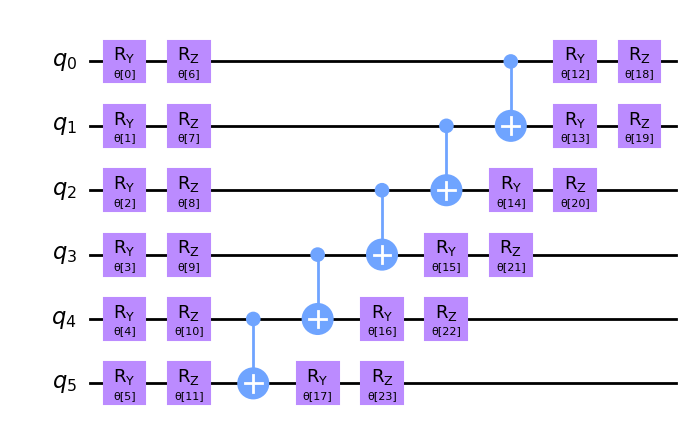

In [64]:
ansatz_6_qb = EfficientSU2(hamiltonian_6_qb.num_qubits, reps=1)
ansatz_6_qb.decompose().draw('mpl')

#### Optimization

In [65]:
x0 = 2 * np.pi * np.random.random(len(ansatz_6_qb.parameters))

In [66]:
#res_6_ng = minimize(cost_func, x0, args=(ansatz_6_qb, hamiltonian_6_qb, estimator), method="cobyla")

In [67]:
res_6_ng_x = [6.26893598,  6.15797434,  6.314182  ,  3.22129014,  6.31107822,
              3.25553103,  2.30048382,  5.35295085,  0.67845075,  1.32445131,
              3.96238379,  1.21979175,  0.98661383,  2.97784466,  6.1847254 ,
              3.0787343 ,  3.27794872,  3.24865384,  4.54424267, -0.74492546,
              4.17659626, -0.10568444,  2.7601689 ,  5.30162617]

#### Quantum Simulator (QS)

In [68]:
vqe_6_ng = ansatz_6_qb.assign_parameters(res_6_ng_x)
vqe_6_ng.measure_all()
transpiled_vqe_6_ng = transpile(vqe_6_ng, backend)
vqe_6_ng_qs = sampler.run(transpiled_vqe_6_ng)

In [69]:
res_vqe_6_ng_qs = vqe_6_ng_qs.result().quasi_dists[0]

{'011010': 0.001, '001011': 0.001, '000010': 0.76, '000111': 0.001, '000011': 0.211, '000000': 0.006, '001010': 0.001, '100010': 0.007, '011011': 0.001, '010010': 0.004, '010011': 0.003, '000100': 0.004}


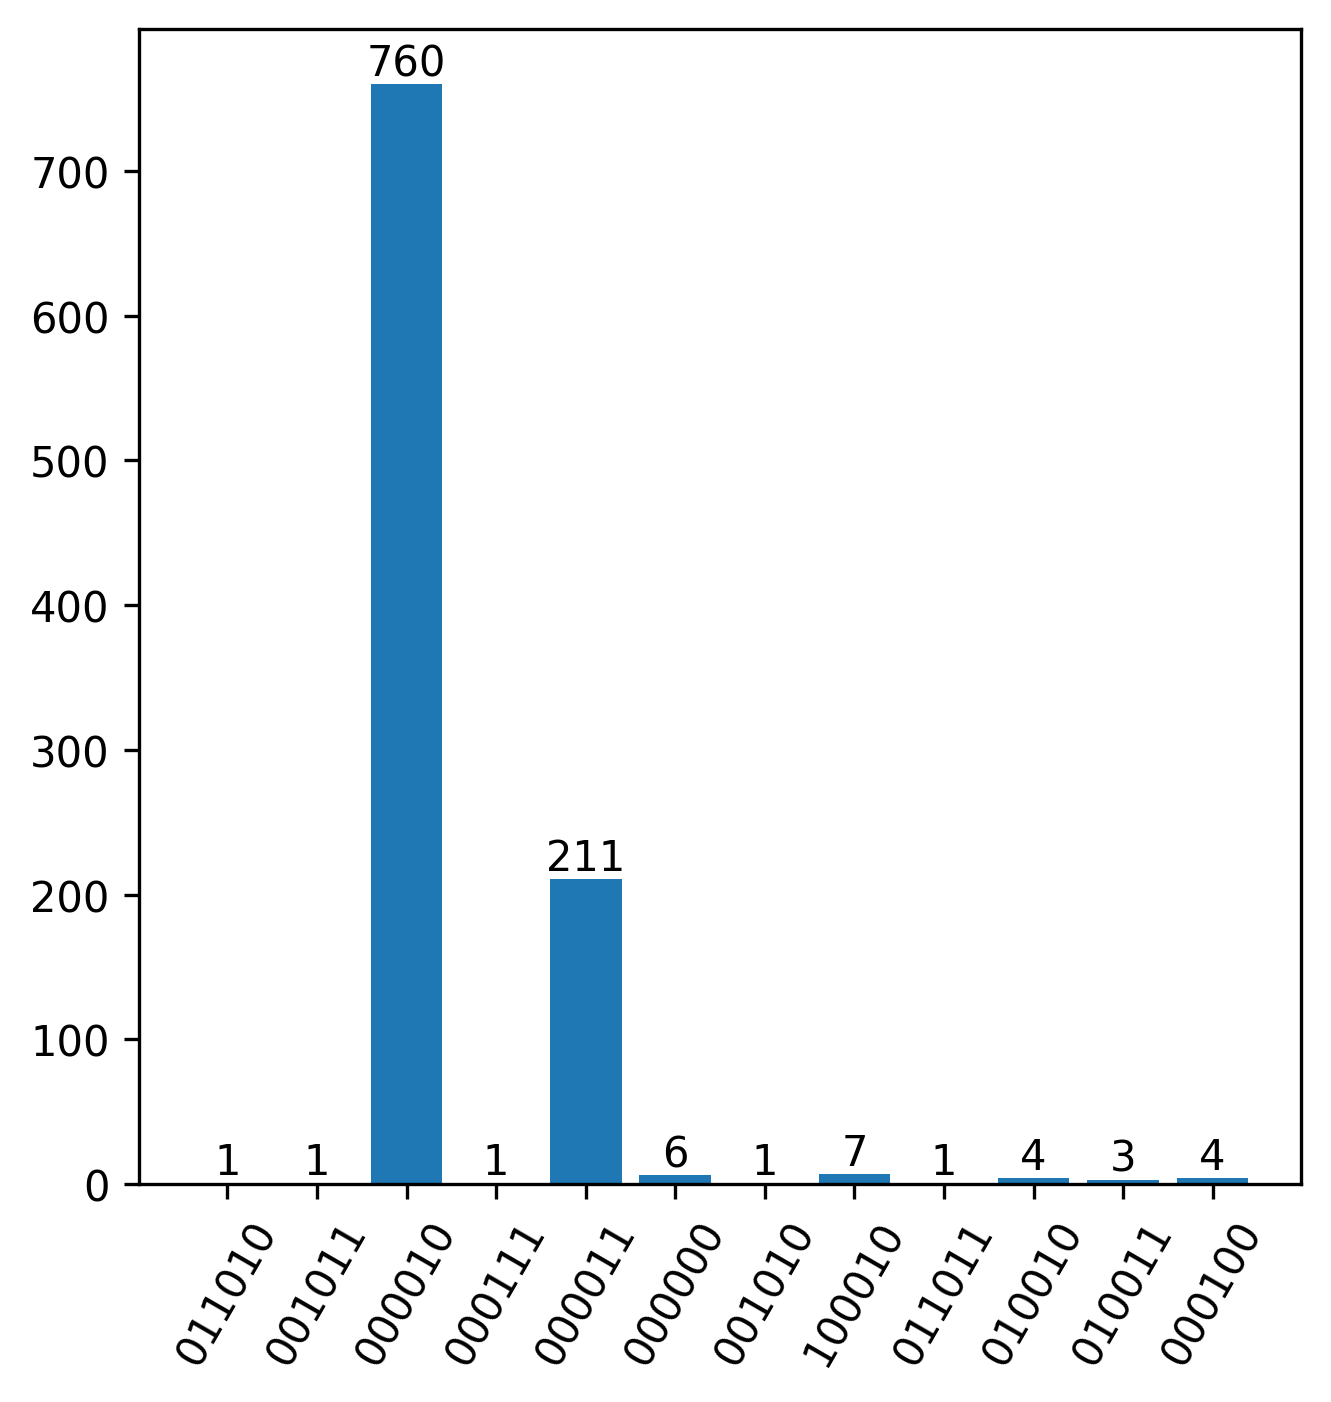

In [70]:
plot_distribution(res_vqe_6_ng_qs.binary_probabilities())
res_dict_6_ng = res_vqe_6_ng_qs.binary_probabilities()
print(res_dict_6_ng)
plt.figure(figsize=(5,5), dpi=300)
round_values = [round(1000 * i) for i in res_dict_6_ng.values()]
counts = plt.bar(range(len(res_dict_6_ng)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_6_ng)), list(res_dict_6_ng.keys()), rotation=60)
plt.show()

### Results 13 qubits

In [71]:
qubits = [sp.Symbol("q1"), sp.Symbol("q2"), sp.Symbol("q3")]

p1, p2, p3 = 39.5, 3.6, 87.8
N = 100
function = -N + p1 * qubits[0] + p2 * qubits[1] +  p3 * qubits[2]

new_asset_prices = [155.87242051728316,
                    189.23569427863737,
                    110.01258122990794,
                    143.25658298950236,
                    126.14314798988245,
                    120.15724542456776,
                    130.4886232515438,
                    148.01167997473527,
                    153.6444221653737,
                    169.26984074036926]

n_ext = 10
for i in range(n_ext):
       
    qubits.append(sp.Symbol(f"q{4 + i}"))
    
    function += new_asset_prices[i] * sp.Symbol(f"q{4 + i}")
    
asset_13_prices = [p1, p2, p3] + new_asset_prices

square_function = function**2

In [72]:
qubo_13_qb = square_function.expand()
qubo_13_qb

1560.25*q1**2 + 10308.601236872*q1*q10 + 11692.9227180041*q1*q11 + 12137.9093510645*q1*q12 + 13372.3174184892*q1*q13 + 284.4*q1*q2 + 6936.2*q1*q3 + 12313.9212208654*q1*q4 + 14949.6198480124*q1*q5 + 8690.99391716273*q1*q6 + 11317.2700561707*q1*q7 + 9965.30869120071*q1*q8 + 9492.42238854085*q1*q9 - 7900.0*q1 + 17027.2807980833*q10**2 + 38627.6806901026*q10*q11 + 40097.6982372772*q10*q12 + 44175.5769524377*q10*q13 + 939.518087411115*q10*q2 + 22913.8022429711*q10*q3 + 40679.1551123719*q10*q4 + 49386.2104329389*q10*q5 + 28710.7805300786*q10*q6 + 37386.7085720414*q10*q7 + 32920.491427631*q10*q8 + 31358.3070582994*q10*q9 - 26097.7246503088*q10 + 21907.4574089435*q11**2 + 45482.3380868888*q11*q12 + 50107.8269940759*q11*q13 + 1065.68409581809*q11*q2 + 25990.8510035635*q11*q3 + 46141.8776449829*q11*q4 + 56018.186042733*q11*q5 + 32566.2939323914*q11*q6 + 42407.2950314327*q11*q7 + 37341.3185025683*q11*q8 + 35569.3515128537*q11*q9 - 29602.3359949471*q11 + 23606.6084625316*q12**2 + 52014.7337411577*

In [73]:
coeffs_13_qb = qubo_matrix(asset_13_prices, qubo_13_qb)
sp.Matrix(np.round(np.triu(coeffs_13_qb), 2))

Matrix([
[-6339.75,   284.4,   6936.2, 12313.92, 14949.62,  8690.99, 11317.27,  9965.31,  9492.42,  10308.6, 11692.92, 12137.91, 13372.32],
[       0, -707.04,   632.16,  1122.28,   1362.5,   792.09,  1031.45,   908.23,   865.13,   939.52,  1065.68,  1106.24,  1218.74],
[       0,       0, -9851.16,  27371.2, 33229.79, 19318.21, 25155.86, 22150.74, 21099.61,  22913.8, 25990.85, 26979.96, 29723.78],
[       0,       0,        0, -6878.27, 58993.25, 34295.85,  44659.5, 39324.48,  37458.4, 40679.16, 46141.88, 47897.86,  52769.0],
[       0,       0,        0,        0, -2036.99, 41636.61, 54218.52, 47741.57, 45476.08, 49386.21, 56018.19, 58150.02, 64063.79],
[       0,       0,        0,        0,        0, -9899.75, 31520.05, 27754.67, 26437.62, 28710.78, 32566.29, 33805.64, 37243.62],
[       0,       0,        0,        0,        0,        0, -8128.87, 36141.67, 34426.63, 37386.71,  42407.3, 44021.15, 48498.04],
[       0,       0,        0,        0,        0,        0,        0, -931

In [74]:
gate_qubo_13_qb = gate_qubo_matrix(coeffs_13_qb, qubo_13_qb)
sp.Matrix(np.round(gate_qubo_13_qb[0],2))

Matrix([
[-57561.07,     71.1,   1734.05,    3078.48,     3737.4,    2172.75,    2829.32,   2491.33,    2373.11,    2577.15,    2923.23,    3034.48,   3343.08],
[        0, -5310.69,    158.04,     280.57,     340.62,     198.02,     257.86,    227.06,     216.28,     234.88,     266.42,     276.56,    304.69],
[        0,        0, -125825.5,     6842.8,    8307.45,    4829.55,    6288.96,   5537.68,     5274.9,    5728.45,    6497.71,    6744.99,   7430.95],
[        0,        0,         0, -218074.25,   14748.31,    8573.96,   11164.88,   9831.12,     9364.6,   10169.79,   11535.47,   11974.46,  13192.25],
[        0,        0,         0,          0, -261594.58,   10409.15,   13554.63,  11935.39,   11369.02,   12346.55,   14004.55,    14537.5,  16015.95],
[        0,        0,         0,          0,          0, -156436.34,    7880.01,   6938.67,     6609.4,     7177.7,    8141.57,    8451.41,   9310.91],
[        0,        0,         0,          0,          0,          0, -201327.64

In [75]:
hamiltonian_13_qb = pauli_z_hamiltonian(gate_qubo_13_qb[0])
hamiltonian_13_qb

SparsePauliOp(['IIIIIIIIIIIIZ', 'IIIIIIIIIIIZI', 'IIIIIIIIIIZII', 'IIIIIIIIIZIII', 'IIIIIIIIZIIII', 'IIIIIIIZIIIII', 'IIIIIIZIIIIII', 'IIIIIZIIIIIII', 'IIIIZIIIIIIII', 'IIIZIIIIIIIII', 'IIZIIIIIIIIII', 'IZIIIIIIIIIII', 'ZIIIIIIIIIIII', 'IIIIIIIIIIIZZ', 'IIIIIIIIIIZIZ', 'IIIIIIIIIZIIZ', 'IIIIIIIIZIIIZ', 'IIIIIIIZIIIIZ', 'IIIIIIZIIIIIZ', 'IIIIIZIIIIIIZ', 'IIIIZIIIIIIIZ', 'IIIZIIIIIIIIZ', 'IIZIIIIIIIIIZ', 'IZIIIIIIIIIIZ', 'ZIIIIIIIIIIIZ', 'IIIIIIIIIIZZI', 'IIIIIIIIIZIZI', 'IIIIIIIIZIIZI', 'IIIIIIIZIIIZI', 'IIIIIIZIIIIZI', 'IIIIIZIIIIIZI', 'IIIIZIIIIIIZI', 'IIIZIIIIIIIZI', 'IIZIIIIIIIIZI', 'IZIIIIIIIIIZI', 'ZIIIIIIIIIIZI', 'IIIIIIIIIZZII', 'IIIIIIIIZIZII', 'IIIIIIIZIIZII', 'IIIIIIZIIIZII', 'IIIIIZIIIIZII', 'IIIIZIIIIIZII', 'IIIZIIIIIIZII', 'IIZIIIIIIIZII', 'IZIIIIIIIIZII', 'ZIIIIIIIIIZII', 'IIIIIIIIZZIII', 'IIIIIIIZIZIII', 'IIIIIIZIIZIII', 'IIIIIZIIIZIII', 'IIIIZIIIIZIII', 'IIIZIIIIIZIII', 'IIZIIIIIIZIII', 'IZIIIIIIIZIII', 'ZIIIIIIIIZIII', 'IIIIIIIZZIIII', 'IIIIIIZIZIIII', 'IIIIIZIIZIIII',

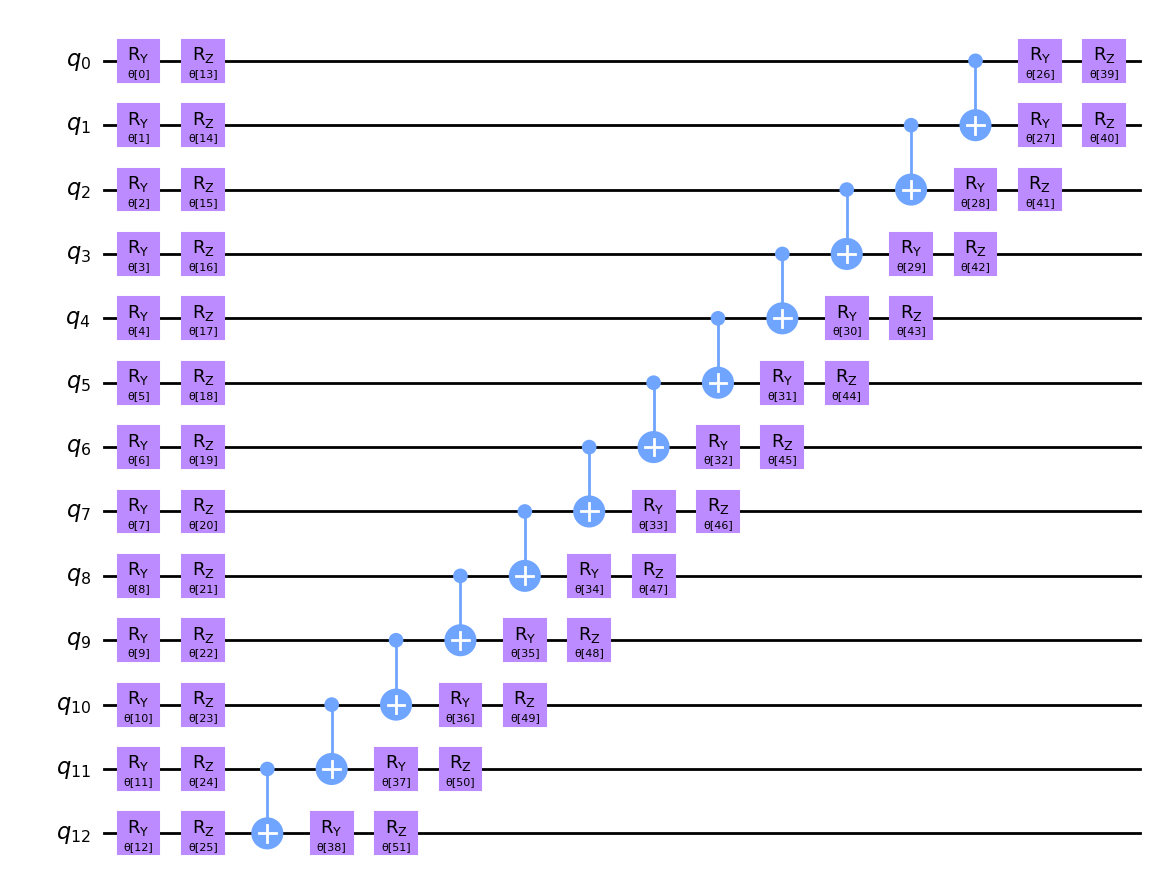

In [76]:
ansatz_13_qb = EfficientSU2(hamiltonian_13_qb.num_qubits, reps=1)
ansatz_13_qb.decompose().draw('mpl')

#### Optimization

In [77]:
x0 = 2 * np.pi * np.random.random(len(ansatz_13_qb.parameters))

In [78]:
#res_vqe_13_qb_ng = minimize(cost_func, x0, args=(ansatz_13_qb, hamiltonian_13_qb, estimator), method="cobyla")

In [79]:
res_vqe_13_qb_ng_x = [1.49389053,  6.13961554,  3.13230757, -0.0460254 ,  6.05913005,
                      6.28658379,  3.25819323,  6.39401695,  0.0288187 ,  3.57261635,
                      1.75702244,  4.75749432,  4.63776102,  6.59380789,  2.53312616,
                      3.62193176, -0.32103884,  2.24193801,  4.85845873,  1.53807847,
                      6.9537974 ,  5.82033445,  4.72692484, -0.04154979,  2.93632445,
                      3.20493971,  4.26488077,  1.70541057,  3.48375256,  3.26658315,
                     -0.02304141,  6.25633649,  3.37826992,  3.64182652,  6.22868426,
                      3.13175378,  4.63430875,  4.72988056,  4.62753999,  5.85782293,
                      1.87389229,  1.29446901,  5.96796502,  2.78043998,  5.73556143,
                      3.1485143 ,  0.53386868,  3.1777644 ,  5.34767517,  1.85035178,
                      3.80128774,  5.63235482]

#### Quantum Simulator (QS)

In [80]:
#sampler = Sampler(session='ibmq_qasm_simulator', options={"shots": 1000})

In [81]:
vqe_13_ng = ansatz_13_qb.assign_parameters(res_vqe_13_qb_ng_x)
vqe_13_ng.measure_all()
transpiled_vqe_13_ng = transpile(vqe_13_ng, backend)
vqe_13_ng_qs = sampler.run(transpiled_vqe_13_ng)

In [82]:
res_vqe_13_ng_qs = vqe_13_ng_qs.result().quasi_dists[0]

In [83]:
bit_str = max(res_vqe_13_ng_qs.binary_probabilities(), key=res_vqe_13_ng_qs.binary_probabilities().get)
prob = res_vqe_13_ng_qs.binary_probabilities()[bit_str]
print((bit_str, prob))

('0000000000010', 0.371)


{'0010000000000': 0.001, '0000010110001': 0.001, '0000011000010': 0.001, '0000000111001': 0.001, '0001010000011': 0.001, '0001000000011': 0.001, '0001000110101': 0.001, '0000000100000': 0.001, '0001010000010': 0.001, '0000011000011': 0.001, '0001100000010': 0.001, '0000000110010': 0.003, '0110010000001': 0.001, '0000000110011': 0.001, '0000010000011': 0.003, '0000000110001': 0.004, '0000110000001': 0.001, '0000000000111': 0.001, '0000010000000': 0.001, '0000000000000': 0.035, '0000010000101': 0.002, '0000010110011': 0.001, '0000010000010': 0.02, '0111000000001': 0.001, '0010000000001': 0.005, '0001000000001': 0.013, '0000010000001': 0.029, '0000000000010': 0.371, '0110010000010': 0.001, '0000000000101': 0.029, '1000000000001': 0.001, '0100011000001': 0.001, '0000001000011': 0.001, '0111010000010': 0.001, '0110000000001': 0.004, '0000000011001': 0.002, '0000000000001': 0.355, '0000001000010': 0.015, '0000000000011': 0.041, '0110000000010': 0.005, '0110000000000': 0.002, '0010000000011':

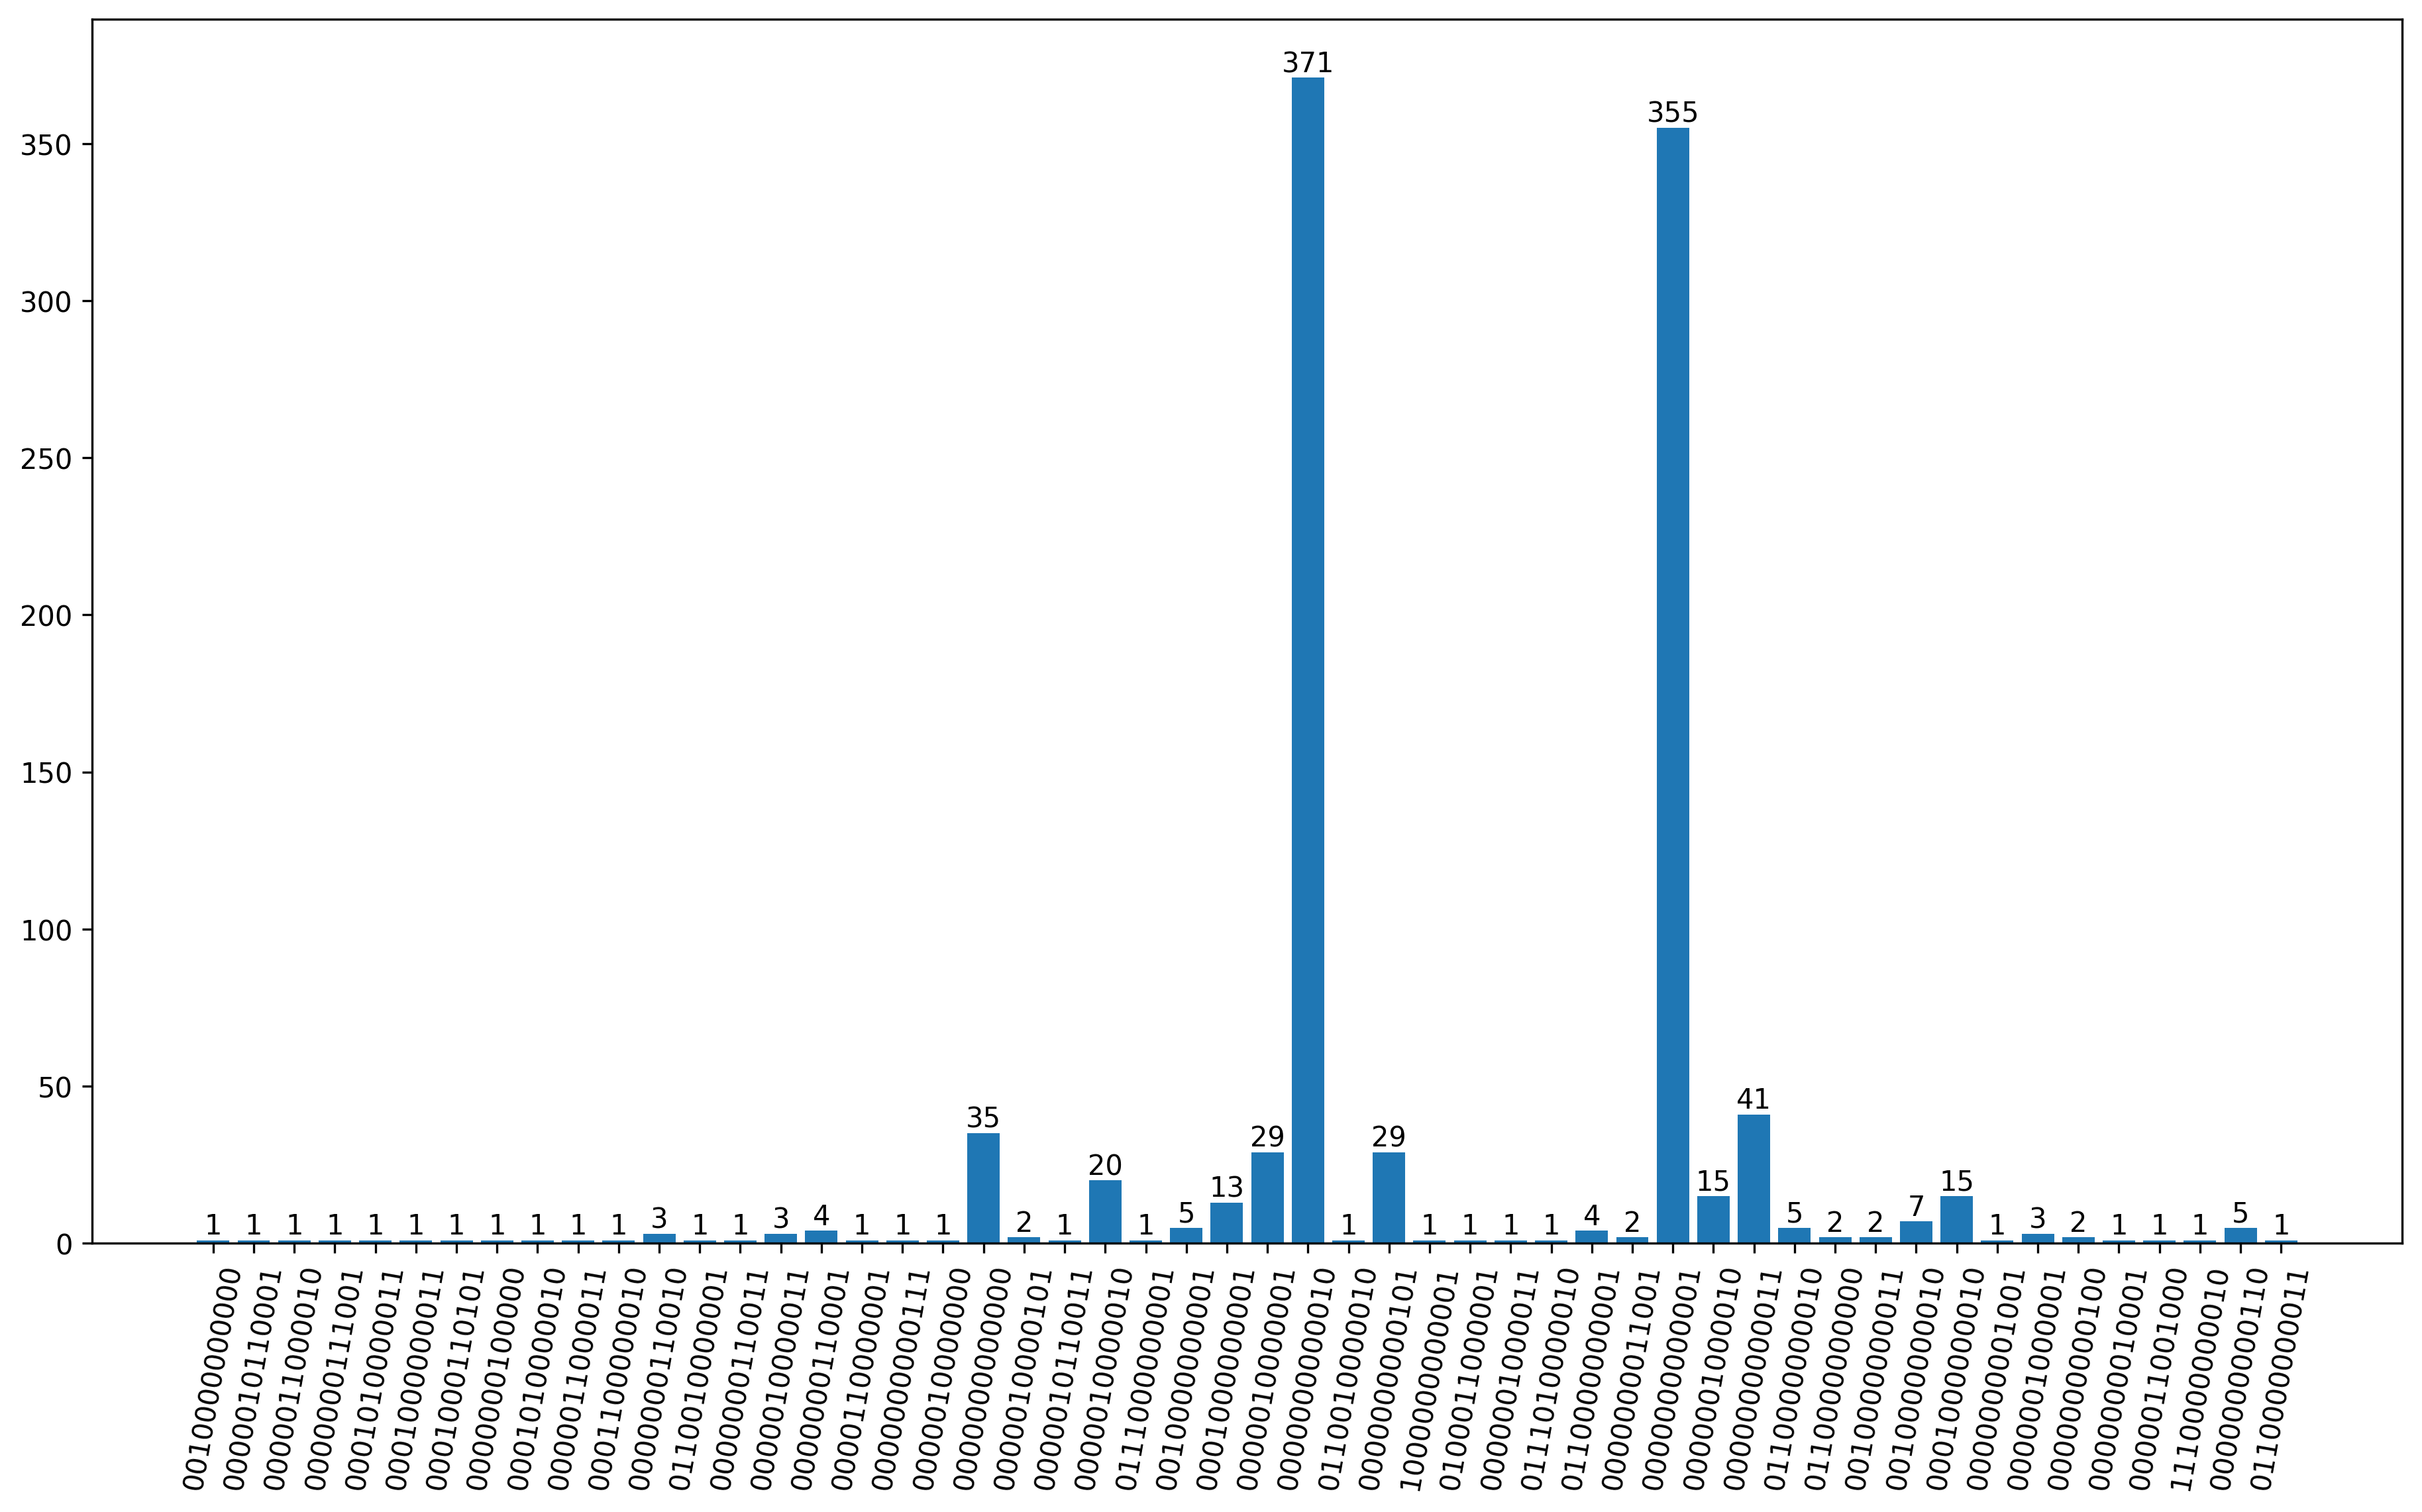

In [84]:
res_dict_13_ng = res_vqe_13_ng_qs.binary_probabilities()
print(res_dict_13_ng)
plt.figure(figsize=(15,8), dpi=300)
round_values = [round(1000 * i) for i in res_dict_13_ng.values()]
counts = plt.bar(range(len(res_dict_13_ng)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_13_ng)), list(res_dict_13_ng.keys()), rotation=80)
plt.show()

### Other

{'010': 0.036, '001': 0.073, '101': 0.091, '110': 0.35, '100': 0.163, '111': 0.165, '000': 0.107, '011': 0.015}


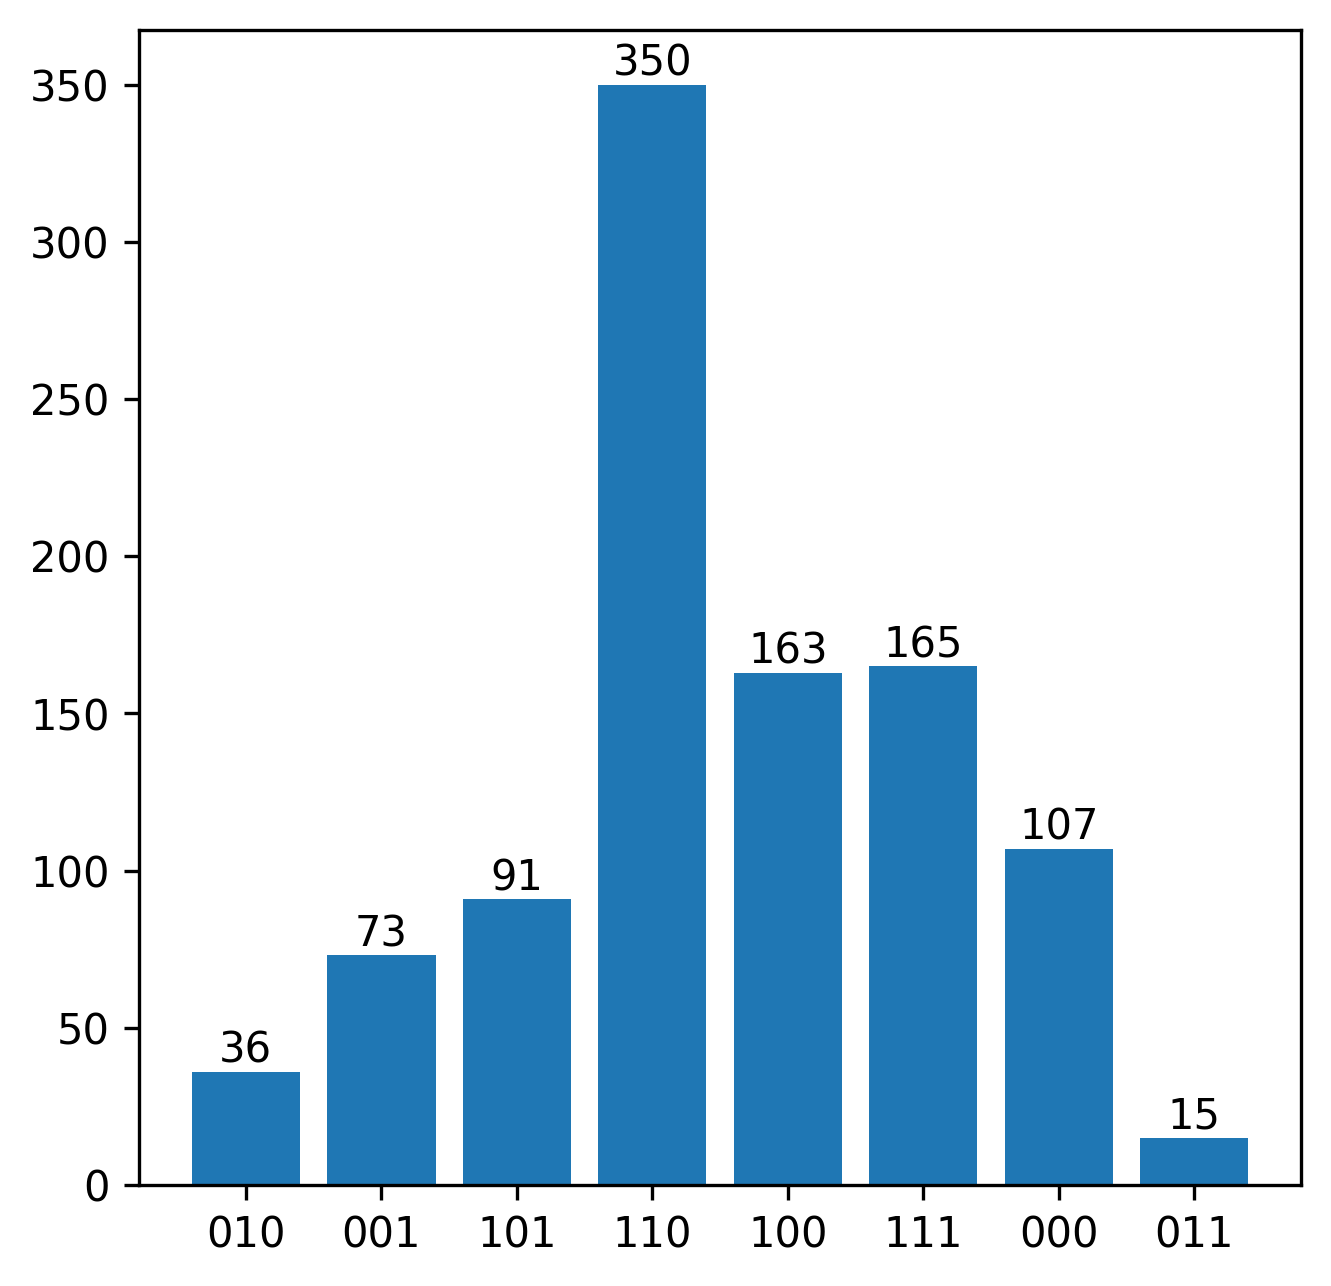

In [85]:
res_3_fd_x = [2.685e+00, 5.852e+00, 4.012e+00, 1.694e+00, 5.769e+00,
              4.842e+00, 1.923e+00, 1.431e+00, 5.772e+00, 4.077e+00,
              3.749e+00, 3.635e+00]

vqe_3_fd = ansatz_3_qb.assign_parameters(res_3_fd_x)
vqe_3_fd.measure_all()
transpiled_vqe_3_fd = transpile(vqe_3_fd, backend)
vqe_3_fd_qs = sampler.run(transpiled_vqe_3_fd)

res_vqe_3_fd_qs = vqe_3_fd_qs.result().quasi_dists[0]
res_dict_3_fd = res_vqe_3_fd_qs.binary_probabilities()
print(res_dict_3_fd)
plt.figure(figsize=(5,5), dpi=300)
round_values = [round(1000 * i) for i in res_dict_3_fd.values()]
counts = plt.bar(range(len(res_dict_3_fd)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_3_fd)), list(res_dict_3_fd.keys()))
plt.show()

{'111': 0.001, '101': 0.01, '100': 0.948, '000': 0.005, '110': 0.036}


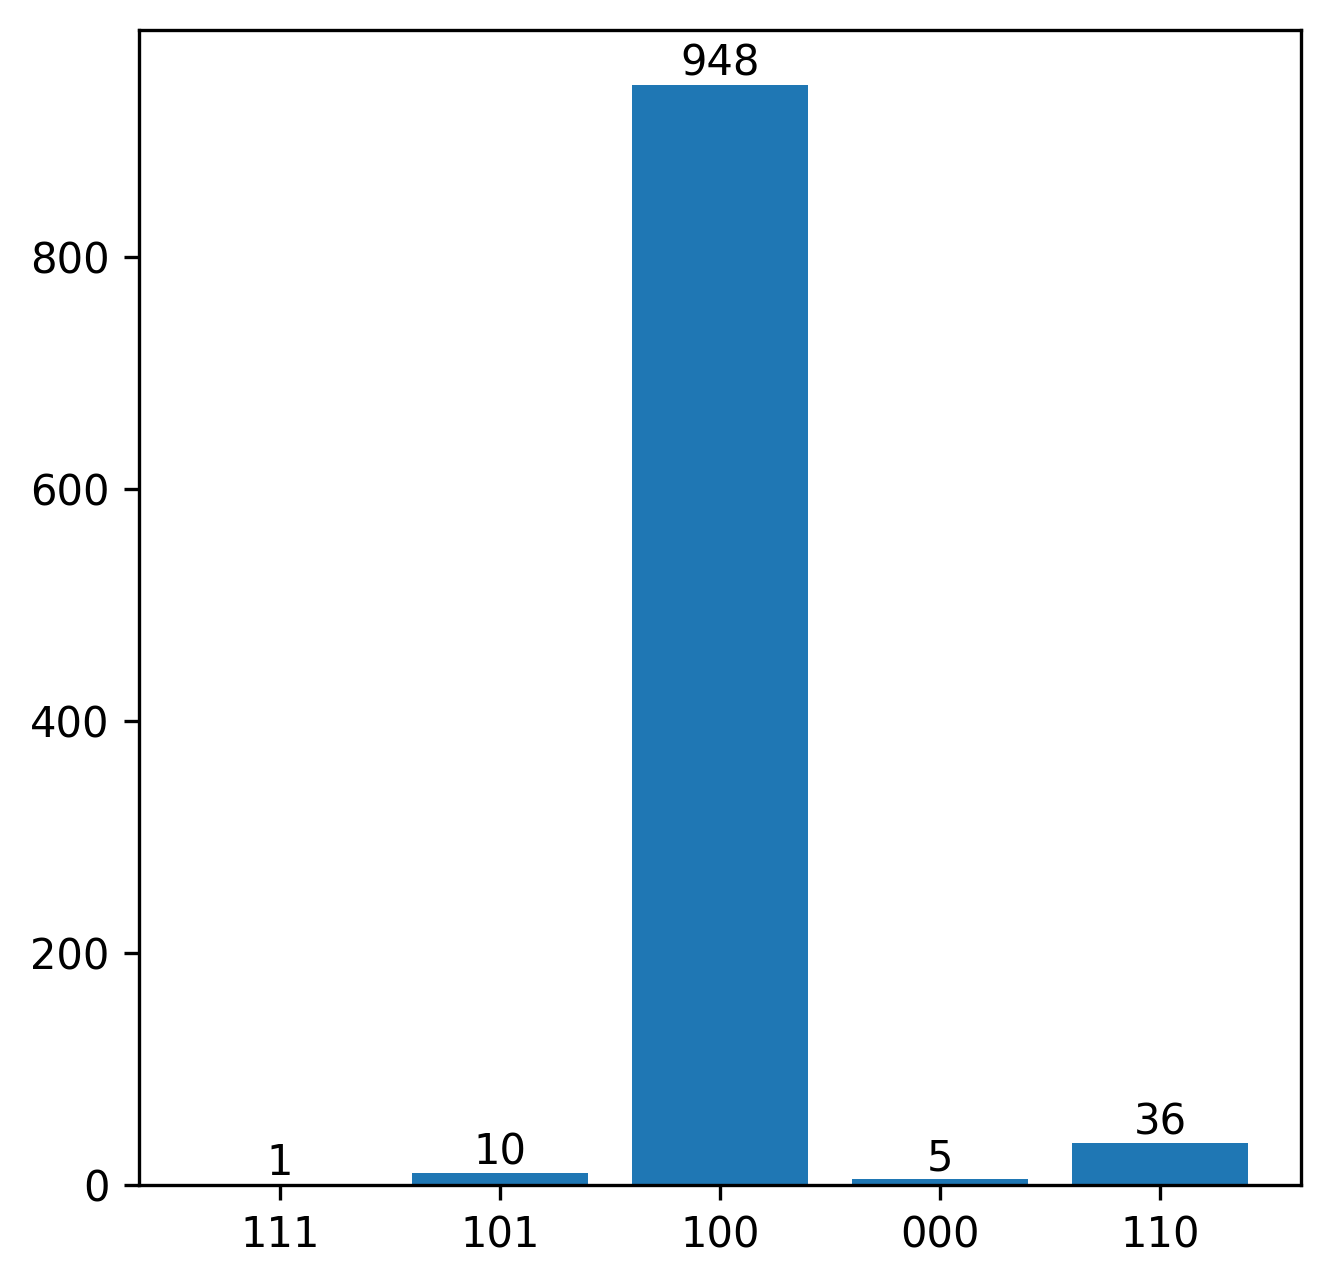

In [86]:
res_3_ng_x =  [3.170e+00, 6.293e+00, 3.915e+00, 8.057e-01, 5.109e+00,
               6.536e+00, 3.309e+00, 2.804e+00, 5.502e+00, 3.952e+00,
               3.765e+00, 3.243e+00]

vqe_3_ng = ansatz_3_qb.assign_parameters(res_3_ng_x)
vqe_3_ng.measure_all()
transpiled_vqe_3_ng = transpile(vqe_3_ng, backend)
vqe_3_ng_qs = sampler.run(transpiled_vqe_3_ng)

res_vqe_3_ng_qs = vqe_3_ng_qs.result().quasi_dists[0]
res_dict_3_ng = res_vqe_3_ng_qs.binary_probabilities()
print(res_dict_3_ng)
plt.figure(figsize=(5,5), dpi=300)
round_values = [round(1000 * i) for i in res_dict_3_ng.values()]
counts = plt.bar(range(len(res_dict_3_ng)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_3_ng)), list(res_dict_3_ng.keys()))
plt.show()